In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# data importing
mnist = fetch_openml('mnist_784')

In [3]:
#data split as data and target and scaling
X = mnist['data']
Y = mnist['target']
X = X/255

# one hot encoding of the labels

number_digits = 10
number_examples = Y.shape[0]

Y = Y.reshape(1, number_examples)
Y_new = np.eye(number_digits)[Y.astype('int32')]
Y_new = Y_new.T.reshape(number_digits, number_examples)

# train test split
number_train_sample = 60000
number_test_sample = X.shape[0] - number_train_sample

X_train, Y_train = X[:number_train_sample].T, Y_new[:,:number_train_sample]
X_test, Y_test = X[number_train_sample:].T, Y_new[:,number_train_sample:]


index = np.random.permutation(number_train_sample)
X_train = X_train[:,index]
Y_train = Y_train[:,index]

In [4]:
# necessary functions

def sigmoid(z):
    return (1/(1+np.exp(-z)))

def prime_sigmoid(z):
    return ((sigmoid(z)*(1-sigmoid(z))))

def softmax(z):
    return ((np.exp(z)/np.sum(np.exp(z), axis=0)))

def multiclass_cross_entropy(y, y_hat):
    m = y.shape[1]
    loss = (-1/m)*(np.sum(np.multiply(y, np.log(y_hat))))
    return loss

def Feedforward(X, params):
    
    forward_prop = {}
    forward_prop["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    forward_prop["A1"] = sigmoid(forward_prop["Z1"])
    forward_prop["Z2"] = np.matmul(params["W2"], forward_prop["A1"]) + params["b2"]
    forward_prop["A2"] = softmax(forward_prop["Z2"])
    
    return forward_prop

def Backpropagation(X, Y, params, forward_prop, bs):
    
    dZ2 = forward_prop["A2"] - Y
    dW2 = (1/bs)*np.matmul(dZ2, forward_prop["A1"].T)
    db2 = (1/bs)*(np.sum(dZ2))
    
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * prime_sigmoid(forward_prop["Z1"])
    dW1 = (1/bs)*np.matmul(dZ1, X.T)
    db1 = (1/bs)*np.sum(dZ1)
    
    gradients = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}
    return gradients

Epoch 1: training_loss = 1.9445037548939077, testing_loss = 1.9366651288513725
Epoch 11: training_loss = 0.5384649207958965, testing_loss = 0.5204894871172429
Epoch 21: training_loss = 0.3988680236707564, testing_loss = 0.38314903939106193
Epoch 31: training_loss = 0.3489967545804882, testing_loss = 0.33533215739135297
Epoch 41: training_loss = 0.3214929792622214, testing_loss = 0.3093620543200802
Epoch 51: training_loss = 0.30283831788655713, testing_loss = 0.2922901702232061
Epoch 61: training_loss = 0.2884407660691635, testing_loss = 0.2792514189515125
Epoch 71: training_loss = 0.2764779973719142, testing_loss = 0.2681970045293822
Epoch 81: training_loss = 0.2658118001413342, testing_loss = 0.25905575297725136
Epoch 91: training_loss = 0.256173627573234, testing_loss = 0.25034157728997464


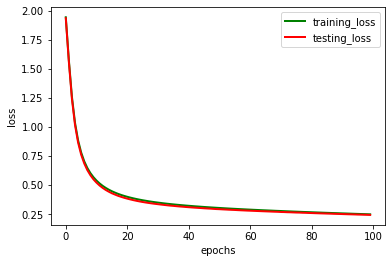

In [9]:
np.random.seed(138)

# defining hyper parameters
number_inputlayers = X_train.shape[0]
number_hiddenlayers = 100
learning_rate = 0.01
beta = 0.9
number_batches = 128
batches = -(-number_train_sample // number_batches)
ilist = []
trl = []
tel = []
#initialiation of weights and biases
#shrink the variance of the weights in each layer for initialization and
#it is done by divinding the parameters by np.sqrt(n)
#- n:number_inputlayers for input layer and n:number_hiddenlayer for hidden layer

parameters = {"W1": (np.random.randn(number_hiddenlayers, number_inputlayers) * np.sqrt(1/number_inputlayers)),
              "b1": (np.zeros((number_hiddenlayers, 1)) * np.sqrt(1/number_inputlayers)),
              "W2": (np.random.randn(number_digits, number_hiddenlayers) * np.sqrt(1/number_hiddenlayers)),
              "b2": (np.zeros((number_digits, 1)) * np.sqrt(1/number_hiddenlayers))}

# training the network model
for i in range(100):
    
    #shuffling the training sets
    index_shuffle = np.random.permutation(X_train.shape[1])
    X_train_sh = X_train[:,index_shuffle]
    Y_train_sh = Y_train[:,index_shuffle]
    
    for j in range(batches):
        
        # defining start and end of the batch
        start = j * number_batches
        end = min(start + number_batches, X_train.shape[1] - 1)
        X = X_train_sh[:, start:end]
        Y = Y_train_sh[:, start:end]
        batch_size = end - start
        
        forward_prop = Feedforward(X, parameters)
        gradiants = Backpropagation(X, Y, parameters, forward_prop, batch_size)
        
        # updating gradients
        parameters["W1"] = parameters["W1"] - learning_rate * gradiants["dW1"]
        parameters["b1"] = parameters["b1"] - learning_rate * gradiants["db1"]
        parameters["W2"] = parameters["W2"] - learning_rate * gradiants["dW2"]
        parameters["b2"] = parameters["b2"] - learning_rate * gradiants["db2"]
        
    forward_prop = Feedforward(X_train, parameters)
    training_loss = multiclass_cross_entropy(Y_train, forward_prop["A2"])
    testing = Feedforward(X_test, parameters)
    testing_loss = multiclass_cross_entropy(Y_test, testing["A2"])
#     plt.plot(range(i,i+1), training_loss,color='green',linewidth=2, markersize=12)
#     plt.plot(range(i,i+1), testing_loss,color='red',linewidth=2, markersize=12)
    if (i%10 == 0):
        print("Epoch {}: training_loss = {}, testing_loss = {}".format(i+1 ,training_loss, testing_loss))
    ilist.append(i)
    trl.append(training_loss)
    tel.append(testing_loss)

plt.plot(ilist, trl,color='green',linewidth=2, markersize=12, label='training_loss')
plt.plot(ilist, tel,color='red',linewidth=2, markersize=12, label='testing_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [10]:
feed_forward = Feedforward(X_test, parameters)
predictions = np.argmax(feed_forward["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[ 965    0    9    2    1   10   13    1    9   12]
 [   0 1110    6    1    2    4    3    9    6    7]
 [   3    2  941   22    4    3    5   24    4    1]
 [   2    2   13  926    0   39    0    5   17   11]
 [   0    0   10    0  924    7    9    6   10   38]
 [   2    1    1   21    0  780   14    0   21    5]
 [   6    4   12    2   11   14  910    0   11    0]
 [   1    2   12   13    2    4    1  954    7   17]
 [   1   14   24   15    4   23    3    3  885    5]
 [   0    0    4    8   34    8    0   26    4  913]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1022
           1       0.98      0.97      0.97      1148
           2       0.91      0.93      0.92      1009
           3       0.92      0.91      0.91      1015
           4       0.94      0.92      0.93      1004
           5       0.87      0.92      0.90       845
           6       0.95      0.94      0.94       970
           7       0.93      0.94   